In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')

In [3]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','issue_d','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

def transform_emp_length(emp_length):
    if emp_length in ["< 1 year", "1 year"]:
        return "0-1 year"
    elif emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "2-5 years"
    elif emp_length in ["6 years", "7 years", "8 years", "9 years", "10 years"]:
        return "6-10 years"
    elif emp_length == "10+ years":
        return "> 10 years"
    
X['emp_length'] = X['emp_length'].apply(transform_emp_length)

In [4]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [5]:
# Dropping variables to avoid multicolinearity and quasi-seperation
X_train = X_train.drop(['home_ownership_NONE', 'funded_amnt', 'total_pymnt'], axis=1)
X_test = X_test.drop(['home_ownership_NONE', 'funded_amnt', 'total_pymnt'], axis=1)

# Drop rows with NaN values in X_train or y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure y_train matches X_train

X_train

,delinq_2yrs,dti,emp_length,inq_last_6mths,installment,loan_amnt,mths_since_last_delinq,pub_rec,total_acc,acc_now_delinq,log_annual_inc,issue_y,issue_m,Effective Federal Funds Rate,state_unemployment,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_ 60 months
65142,-0.341529,1.421472,8,0.086353,-0.890206,-0.998913,-0.688431,-0.324184,-1.105417,-0.052479,-1.718594,2013,9,-0.200075,0.809096,0,0,0,1,0
171393,-0.341529,0.191081,1,-0.753278,1.339314,2.482795,-0.688431,-0.324184,0.756691,-0.052479,0.563782,2014,10,-0.167648,-0.960412,1,0,0,0,1
124957,-0.341529,0.852911,1,0.086353,-0.570249,-0.576702,-0.688431,-0.324184,-0.174363,-0.052479,0.319472,2012,10,0.059345,1.472661,0,0,0,1,0
198460,-0.341529,-1.703696,10,0.086353,-1.190132,-1.188601,1.341060,1.975819,1.433821,-0.052479,-0.907534,2014,5,-0.167648,-0.518035,0,0,1,0,0
12074,-0.341529,-0.472027,3,-0.753278,-0.197244,-0.331942,1.341060,-0.324184,-0.766852,-0.052479,-1.503731,2011,6,-0.167648,0.034936,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,-0.341529,1.517297,1,0.925985,0.428094,0.182053,-0.688431,-0.324184,1.349180,-0.052479,0.009884,2015,1,-0.102793,-1.458086,1,0,0,0,0
103694,-0.341529,1.996421,1,-0.753278,-0.472458,-0.521631,-0.688431,-0.324184,0.925973,-0.052479,-0.395415,2013,2,0.026917,-0.407441,1,0,0,0,0
131932,-0.341529,-0.141112,1,-0.753278,0.771705,0.885737,-0.688431,-0.324184,1.518462,-0.052479,1.798427,2012,9,-0.005510,0.919690,1,0,0,0,1
146867,-0.341529,-1.181131,6,1.765617,0.007823,-0.209563,0.855747,-0.324184,0.925973,-0.052479,0.319472,2012,5,0.059345,-0.352144,0,0,0,1,0


In [6]:
np.asarray(X_train)

array([[-0.34152859,  1.4214719 ,  8.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.34152859,  0.19108089,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.34152859,  0.85291115,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.34152859, -0.1411119 ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.34152859, -1.18113088,  6.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.34152859,  1.75238703,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
# Using statsmodels library to run Logit Regression

# Add a constant to the independent variables
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)

# Fit the model and obtain the result object
result = logit_model.fit(maxiter=2000)

# Print the summary of the logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.482411
         Iterations 8
                            Logit Regression Results                           
Dep. Variable:     loan_status_grouped   No. Observations:               205578
Model:                           Logit   Df Residuals:                   205557
Method:                            MLE   Df Model:                           20
Date:                 Sat, 26 Oct 2024   Pseudo R-squ.:                 0.07385
Time:                         00:02:00   Log-Likelihood:                -99173.
converged:                        True   LL-Null:                   -1.0708e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -284.3239     12.260    -23.190   

Accuracy: 0.78 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.97      0.87     40785
         1.0       0.43      0.09      0.14     11259

    accuracy                           0.78     52044
   macro avg       0.61      0.53      0.51     52044
weighted avg       0.72      0.78      0.71     52044



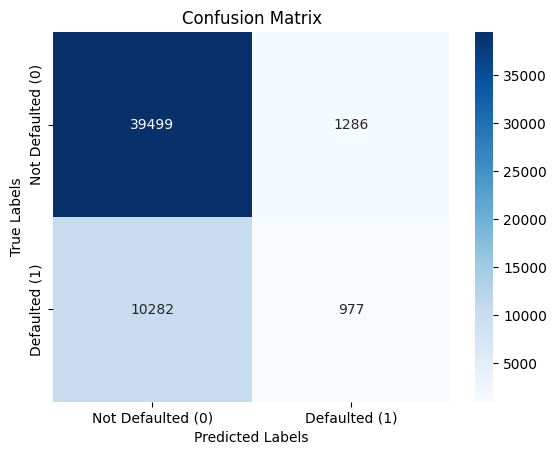

In [8]:
# Make predictions
threshold = 0.5
predicted_probs = result.predict(X_test_with_const)  # Predict probabilities
predicted_classes = np.where(predicted_probs < threshold, 0, 1)

# Generate evaluation metrics
accuracy = accuracy_score(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Print the accuracy score and classication report
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['Not Defaulted (0)', 'Defaulted (1)'], yticklabels=['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

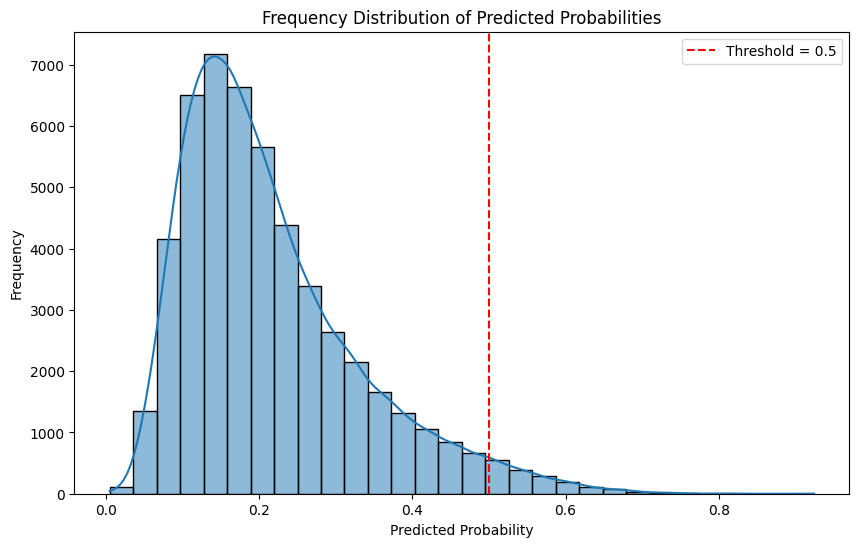

In [9]:
# Don't keep this
# Just to show how weird the predictions from statsmodels logit regression are

plt.figure(figsize=(10, 6))
sns.histplot(predicted_probs, bins=30, kde=True)  # Use KDE for a smoother curve
plt.title('Frequency Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold = {}'.format(threshold))
plt.legend()
plt.show()